In [49]:
import pandas as pd
import numpy as np
import seaborn as sns

from pandas_profiling import ProfileReport
from geopy.distance import geodesic
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 1.2.0
Numpy Version: 1.18.5
Seaborn Version: 0.11.1


In [50]:
# Switch between recalculating or reading from file to save time

READ_STATION_DISTANCES_FROM_FILE = True

In [51]:
df = pd.read_csv("../data/call_a_bike/OPENDATA_BOOKING_CALL_A_BIKE.csv", sep=";")

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16228298 entries, 0 to 16228297
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   BOOKING_HAL_ID             int64  
 1   CATEGORY_HAL_ID            int64  
 2   VEHICLE_HAL_ID             int64  
 3   CUSTOMER_HAL_ID            object 
 4   DATE_BOOKING               object 
 5   DATE_FROM                  object 
 6   DATE_UNTIL                 object 
 7   COMPUTE_EXTRA_BOOKING_FEE  object 
 8   TRAVERSE_USE               object 
 9   DISTANCE                   float64
 10  START_RENTAL_ZONE          object 
 11  START_RENTAL_ZONE_HAL_ID   float64
 12  END_RENTAL_ZONE            object 
 13  END_RENTAL_ZONE_HAL_ID     float64
 14  RENTAL_ZONE_HAL_SRC        object 
 15  CITY_RENTAL_ZONE           object 
 16  TECHNICAL_INCOME_CHANNEL   object 
dtypes: float64(3), int64(3), object(11)
memory usage: 2.1+ GB


In [53]:
df.head(3)

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
0,21366843,51000,143517,A821059B555C7764A2FF801180874A2FCB326222,2014-01-01 00:34:54,2014-01-01 00:34:54,2014-01-01 00:50:14,Nein,Nein,0.0,U-Bahn Baumwall,214170.0,Mönckebergstraße / Rosenstraße,131880.0,Standort,Hamburg,iPhone SRH
1,21367069,51000,119830,1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2,2014-01-01 01:39:55,2014-01-01 01:39:55,2014-01-01 01:57:27,Nein,Nein,0.0,Bahnhof Altona Ost/Max-Brauer-Allee,131646.0,Schulterblatt/Eifflerstraße,131648.0,Standort,Hamburg,Android SRH
2,21367072,51000,143501,7AD2C1B70137479062A6DD73815835986677BB2D,2014-01-01 01:40:20,2014-01-01 01:40:20,2014-01-01 01:53:09,Nein,Nein,0.0,Weidestraße/Biedermannplatz,211922.0,Jarrestraße / Rambatzweg,138376.0,Standort,Hamburg,Techniker HH_119 (-2334-)


In [54]:
df.tail(3)

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
16228295,46385839,51000,120488,CC6405146B51242A9169AB55E88A5C472EA1B2AA,2017-05-16 07:40:17,2017-05-16 07:40:17,2017-05-16 07:50:07,Ja,Nein,0.0,Weidestraße/Biedermannplatz,211922.0,Mundsburg / Schürbeker Straße,140799.0,Standort,Hamburg,Techniker HH_119 (-2334-)
16228296,46386510,50000,116623,AE105561D195C422985C2B3BB1A790C187DA3A70,2017-05-16 08:02:12,2017-05-16 08:02:12,2017-05-23 08:02:12,Ja,Nein,NaN,NaN,NaN,NaN,NaN,NaN,Darmstadt,iPhone CAB
16228297,46386791,50000,110529,DBB967CDDB3C6D5F0C7CC7A2FF2E8CC89B5ECE6E,2017-05-16 08:11:13,2017-05-16 08:11:13,2017-05-23 08:11:13,Ja,Nein,NaN,NaN,NaN,NaN,NaN,NaN,Darmstadt,iPhone CAB


In [55]:
# Select trips made in Hamburg

trips = df[df.CITY_RENTAL_ZONE == "Hamburg"]

In [56]:
last_count = trips.shape[0]

def print_count_data():
    current_count = trips.shape[0]
    diff = current_count - last_count
    print('% s entries, diff: % s'%(current_count, diff)) 
    return current_count

In [57]:
last_count = print_count_data()

8942261 entries, diff: 0


In [58]:
# Select and rename usable columns

trips = trips[[
    "VEHICLE_HAL_ID",
    "CUSTOMER_HAL_ID",
    "DATE_FROM",
    "DATE_UNTIL",
    "START_RENTAL_ZONE",
    "START_RENTAL_ZONE_HAL_ID",
    "END_RENTAL_ZONE",
    "END_RENTAL_ZONE_HAL_ID",
    "TECHNICAL_INCOME_CHANNEL",
]].copy()
trips.columns = [
    "bike_id",
    "user_id",
    "date_from",
    "date_until",
    "start_station_name", 
    "start_station_id",
    "end_station_name",
    "end_station_id",
    "booked_via"
]

In [59]:
trips.isna().sum()

bike_id                    0
user_id                    0
date_from                  0
date_until                 0
start_station_name       429
start_station_id         246
end_station_name         255
end_station_id           250
booked_via            120066
dtype: int64

In [60]:
# Fill unknown 'booked_via' with 'Unknown' because there are a lot (120,066)
# Drop other NaN rows since the amount is negligible

trips = trips.fillna({'booked_via': 'Unknown'})
trips = trips.dropna()

In [61]:
last_count = print_count_data()

8941801 entries, diff: -460


In [62]:
# Convert float IDs to integer values

trips["start_station_id"] = trips["start_station_id"].astype(int)
trips["end_station_id"] = trips["end_station_id"].astype(int)

In [63]:
# Examining 'booked_via' that start with 'Techniker'

techniker = trips[trips["booked_via"].str.contains("Techniker")]
non_techniker = pd.concat([trips, techniker]).drop_duplicates(keep=False)

tmp = non_techniker.loc[non_techniker.user_id.isin(techniker.user_id.unique())]
print('Number of trips with a user ID that booked via Techniker before: %s' % len(tmp.index))
tmp = non_techniker.loc[~non_techniker.user_id.isin(techniker.user_id.unique())]
print('Number of trips with a user ID that did not book via Techniker before: %s' % len(tmp.index))

# Assuming 'Techniker' means maintenance personnel is probably faulty.
# Around 50% of the user IDs are contained in the non_techniker trip data set.

Number of trips with a user ID that booked via Techniker before: 4104569
Number of trips with a user ID that did not book via Techniker before: 4108149


In [64]:
non_techniker.sample(5)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via
3021648,119608,F71AE2C096891A9906643EFA8A2762B321B6B3D6,2014-09-05 17:08:58,2014-09-05 17:38:14,Hauptbahnhof Ost / Hachmannplatz,131873,Sternschanze / Eingang Dänenweg,139501,Terminal HH_34 (-2541-)
13811525,117530,391E2FCB6A8C97EC66DDF37A6FA263D4CF40A04E,2016-10-18 16:17:51,2016-10-18 16:27:49,Bahnhof Dammtor Süd / Marseiller Straße,138382,Millerntorplatz/St.Pauli,131905,Terminal HH_18 (-2528-)
7144280,120392,CF82FA58B034B84EBE541D2BA145F1D57B13B656,2015-08-13 19:52:22,2015-08-13 20:02:04,Krausestraße/Eilbektal,208295,Mundsburg / Schürbeker Straße,140799,IVR
11734930,117500,57486D611B91BE82D3C4BC5D6BFB4773111A3998,2016-07-10 23:16:13,2016-07-10 23:26:29,Millerntorplatz/St.Pauli,131905,Allende-Platz/Grindelhof,198077,Terminal HH_4 (-2612-)
12803747,119653,661147FEF654DD130F9D5CEB868104B0DF5379A2,2016-08-28 00:53:14,2016-08-28 00:57:54,Saarlandstraße/Wiesendamm,203890,Weidestraße /Johannes-Prassek-Park,247852,Android SRH


In [65]:
# Create a stations data set from all unique station IDs

station_ids = sorted(
    set(trips.start_station_id.tolist() + trips.end_station_id.tolist())
)
station_ids = pd.DataFrame(station_ids, columns=['station_id'])
station_ids

,station_id
0,131543
1,131546
2,131547
3,131639
4,131640
...,...
211,256467
212,264330
213,264820
214,264821


In [66]:
# Load DB data set about stations

db_stations = pd.read_csv("../data/call_a_bike/OPENDATA_RENTAL_ZONE_CALL_A_BIKE.csv", sep=";", decimal=",")
db_stations = db_stations[db_stations.CITY == "Hamburg"]
db_stations.sample(5)

,RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,NAME,CODE,TYPE,CITY,COUNTRY,LATITUDE,LONGITUDE,POI_AIRPORT_X,POI_LONG_DISTANCE_TRAINS_X,POI_SUBURBAN_TRAINS_X,POI_UNDERGROUND_X,ACTIVE_X,COMPANY,COMPANY_GROUP
1056,268358,Standort,Sieldeich/ Gresham Carat Hotel,2690.0,normal,Hamburg,Deutschland,10.021814,53.528309,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
526,208307,Standort,Schleidenstraße/Osterbekstraße,2336.0,normal,Hamburg,Deutschland,10.033690,53.584582,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
371,131875,Standort,Jacobikirche / Steinstraße,2637.0,normal,Hamburg,Deutschland,10.001500,53.550300,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
624,227415,Standort,Wandsbeker Chaussee/ Börnestraße,2413.0,normal,Hamburg,Deutschland,10.059528,53.570470,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
541,211711,Standort,Fischersallee/Bleickenallee,2125.0,normal,Hamburg,Deutschland,9.922260,53.550966,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike


In [67]:
# Select coordinates for stations from DB data

coordinates = db_stations[["RENTAL_ZONE_HAL_ID", "NAME", "LATITUDE", "LONGITUDE"]].copy()
# coordinate descriptions are incorrectly labelled in the original data set
coordinates.columns = ["station_id", "name", "longitude", "latitude"]
coordinates.dropna(inplace=True)
coordinates

,station_id,name,longitude,latitude
350,131543,Landungsbrücke/Hafentor,9.972300,53.545700
351,131546,Fischmarkt/Breite Straße,9.950880,53.546200
352,131547,Paulinenplatz/Wohlwillstraße,9.962460,53.554200
353,131639,Burgstraße/Hammer Landstraße,10.041298,53.555693
354,131640,Innocentiapark/Oberstraße,9.982110,53.577248
...,...,...,...,...
1023,256467,Röntgenstraße/Philips,10.012209,53.623481
1048,264330,Bleickenallee/Kinderkrankenhaus Altona,9.912913,53.551288
1050,264820,Osterstraße/Heußweg,9.952071,53.575983
1051,264821,Bahrenfelder Chaussee/Von-Sauer-Straße,9.910870,53.565973


We can already see that the DB data set of stations does not seem to be complete. There are more unique IDs in the bike trip data set as in the stations data set (308 rows vs. 206 rows).

In [68]:
stations = pd.merge(station_ids, coordinates, how="left", on="station_id")
stations

,station_id,name,longitude,latitude
0,131543,Landungsbrücke/Hafentor,9.972300,53.545700
1,131546,Fischmarkt/Breite Straße,9.950880,53.546200
2,131547,Paulinenplatz/Wohlwillstraße,9.962460,53.554200
3,131639,Burgstraße/Hammer Landstraße,10.041298,53.555693
4,131640,Innocentiapark/Oberstraße,9.982110,53.577248
...,...,...,...,...
211,256467,Röntgenstraße/Philips,10.012209,53.623481
212,264330,Bleickenallee/Kinderkrankenhaus Altona,9.912913,53.551288
213,264820,Osterstraße/Heußweg,9.952071,53.575983
214,264821,Bahrenfelder Chaussee/Von-Sauer-Straße,9.910870,53.565973


In [69]:
missing_info_ids = stations[stations.name.isnull()].station_id.unique()
missing_info_ids

array([138370, 194453, 194553, 194563, 225361, 238540, 238543, 241576,
       242731, 246950])

In [70]:
a = df[df.START_RENTAL_ZONE_HAL_ID.isin(missing_info_ids)].START_RENTAL_ZONE.unique()
b = df[df.END_RENTAL_ZONE_HAL_ID.isin(missing_info_ids)].END_RENTAL_ZONE.unique()

missing_locations = list(set(a)|set(b))
missing_locations

['Systemtechnik/Test Terminal',
 'Rotec Schlösser BSC',
 'F PS 1763 / BSC Hamburg Mobil',
 'F R  5156 / BSC Hamburg Mobil',
 'BSC Testterminal Halle',
 'Maretstraße/Baererstraße',
 'F PS 2423 / BSC Hamburg Mobil',
 'BSCTerminal FFM 2.OG R 2.21',
 'Funkbox-BSC-HH',
 'Grindelberg / Bezirksamt Eimsbüttel']

To match missing stations with coordinates, the information available at https://web.archive.org/web/20210313100715/https://suche.transparenz.hamburg.de/dataset/stadtrad-stationen-hamburg20 was considered. Only two stations are included: *Grindelberg / Bezirksamt Eimsbüttel* (ID 138370) and *Maretstraße/Baererstraße* (ID 242731). Coordinates for both stations can easily be added to the data set by hand.

**Coordinates**
* Grindelberg / Bezirksamt Eimsbüttel: [ 9.97782399971897, 53.57540799556665 ]
* Maretstraße / Baererstraße: [ 9.982274994484669, 53.453703999218654 ]

In [71]:
print(df[df.START_RENTAL_ZONE == "Grindelberg / Bezirksamt Eimsbüttel"].START_RENTAL_ZONE_HAL_ID.unique())
print(df[df.END_RENTAL_ZONE == "Grindelberg / Bezirksamt Eimsbüttel"].END_RENTAL_ZONE_HAL_ID.unique())

print(df[df.START_RENTAL_ZONE == "Maretstraße/Baererstraße"].START_RENTAL_ZONE_HAL_ID.unique())
print(df[df.END_RENTAL_ZONE == "Maretstraße/Baererstraße"].END_RENTAL_ZONE_HAL_ID.unique())

[138370.]
[138370.]
[242731.]
[242731.]


In [72]:
stations.loc[stations.station_id == 138370, "name"] = "Grindelberg / Bezirksamt Eimsbüttel"
stations.loc[stations.station_id == 138370, "longitude"] = 9.977824
stations.loc[stations.station_id == 138370, "latitude"] = 53.575408

stations.loc[stations.station_id == 242731, "name"] = "Maretstraße/Baererstraße"
stations.loc[stations.station_id == 242731, "longitude"] = 9.982275
stations.loc[stations.station_id == 242731, "latitude"] = 53.453704

# Drop the remaining station IDs with unknown location
stations = stations.dropna().reset_index()

In [73]:
# Remove the added locations from the set of missing locations

missing_locations.remove("Grindelberg / Bezirksamt Eimsbüttel")
missing_locations.remove("Maretstraße/Baererstraße")
missing_locations

['Systemtechnik/Test Terminal',
 'Rotec Schlösser BSC',
 'F PS 1763 / BSC Hamburg Mobil',
 'F R  5156 / BSC Hamburg Mobil',
 'BSC Testterminal Halle',
 'F PS 2423 / BSC Hamburg Mobil',
 'BSCTerminal FFM 2.OG R 2.21',
 'Funkbox-BSC-HH']

In [74]:
# Remove all trips where either the start or end station is still of unknown location

nan_trips = trips[
    (trips.start_station_name.isin(missing_locations)) |
    (trips.end_station_name.isin(missing_locations))
]
trips.drop(nan_trips.index, inplace=True) 

In [75]:
last_count = print_count_data()

8923066 entries, diff: -18735


In [76]:
# Calculate duration in minutes (rounded up) for each trip

def calculate_duration_in_min(date_from, date_until):
    duration_in_seconds = pd.to_datetime(date_until) - pd.to_datetime(date_from)
    return np.ceil(duration_in_seconds / pd.Timedelta(minutes=1))

trips.loc[:, "duration_in_min"] = calculate_duration_in_min(trips["date_from"], trips["date_until"])
trips["duration_in_min"] = trips["duration_in_min"].astype(int)

In [77]:
# Remove trips shorter than 3 minutes starting and ending at the same station
# These are probably trips that were not intentional or canceled due to issues with the bike

mask = (trips.duration_in_min < 3) & (trips.start_station_id == trips.end_station_id)
trips = trips.drop(trips[mask].index)

In [78]:
last_count = print_count_data()

8476307 entries, diff: -446759


Duration for 75 of the trips: 22 minutes


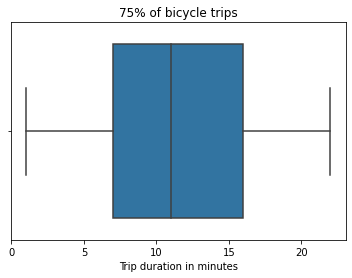

Duration for 85 of the trips: 28 minutes


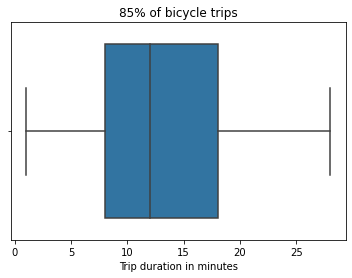

Duration for 90 of the trips: 33 minutes


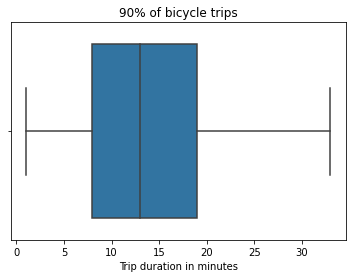

Duration for 93 of the trips: 39 minutes


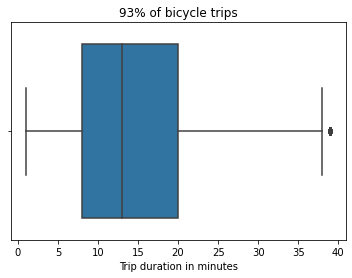

Duration for 95 of the trips: 49 minutes


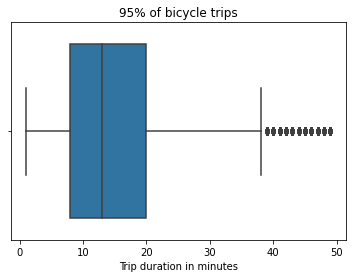

Duration for 99 of the trips: 208 minutes


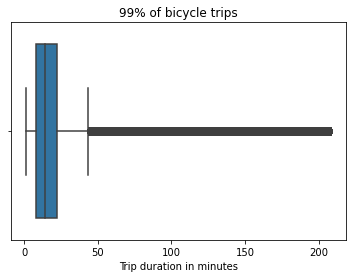

In [79]:
quantiles = [0.75, 0.85, 0.90, 0.93, 0.95, 0.99]

for quantile in quantiles:
    threshold = trips.duration_in_min.quantile(quantile)
    print('Duration for {0} of the trips: {1} minutes'.format(int(quantile*100), int(threshold)))
    sns.boxplot(x='duration_in_min', data=trips[trips.duration_in_min <= threshold])
    plt.title('{}% of bicycle trips'.format(int(quantile*100), threshold))
    plt.xlabel('Trip duration in minutes')
    plt.savefig('figures/duration_in_min_quantile_{}.png'.format(int(quantile*100)))
    plt.show()

In [80]:
# Remove outliers based on trip duration

threshold = trips.duration_in_min.quantile(0.9)
print('Trip duration threshold: %s minutes' % threshold)

trips.drop(trips[trips.duration_in_min > threshold].index, inplace=True) 

Trip duration threshold: 33.0 minutes


In [81]:
last_count = print_count_data()

7669950 entries, diff: -806357


In [82]:
# Calculate the distance between each pair of station and save it as a python dict for easier lookup

def calculate_distance(id_x, id_y):
    station_x = stations_by_id.loc[id_x]
    station_y = stations_by_id.loc[id_y]
    x = (station_x.latitude, station_x.longitude)
    y = (station_y.latitude, station_y.longitude)
    return geodesic(x, y).km

if READ_STATION_DISTANCES_FROM_FILE:
    distances = np.load("calculations/station_distances.npy", allow_pickle=True).item()
else:
    stations_by_id = stations.set_index("station_id")
    ids = stations.station_id.to_numpy()
    distances = {}

    for station_x in ids:
        distances[station_x] = {}
        for station_y in ids:
            distances[station_x][station_y] = calculate_distance(station_x, station_y)

    np.save("calculations/station_distances.npy", distances) 

In [83]:
# Assign distance to each trip

trips["distance_in_km"] = trips.apply(lambda x: distances[x.start_station_id][x.end_station_id], axis=1)

In [84]:
trips.sample(4)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km
14148232,110581,E382A6BB6399700912CDD839FAC9275010578DC4,2016-11-12 17:29:19,2016-11-12 17:37:17,Berliner Tor / Berlinertordamm,131652,Lange Reihe / Lohmühlenpark,138385,iPhone SRH,8,0.976115
1844396,118994,0B2EC0016CD50CFBD5C12079EB58D441291A7225,2014-06-25 17:47:32,2014-06-25 18:13:43,Hauptbahnhof Ost / Hachmannplatz,131873,Kurze Mühren/Spitalerstraße,131647,IVR,27,0.299164
13130924,120228,8A9C637B376ABEFA8A7BC56E3FBF54A31CD80F32,2016-09-11 15:15:27,2016-09-11 15:27:48,Hudtwalckerstraße / Bebelallee,138378,Leinpfad/Fernsicht,224650,Terminal HH_72 (-2369-),13,1.566832
880300,143531,89A234F7F96E77DA63C72AF8A137B5FF0AED2EE2,2014-04-24 14:41:10,2014-04-24 14:48:55,Jarrestraße / Rambatzweg,138376,Wiesendamm/Roggenkamp,212607,Terminal HH_75 (-2364-),8,1.486782


In [89]:
# Save prepared datasets

stations.to_csv('../data/clean/stations.csv', index=False)
trips.to_csv('../data/clean/trips.csv', index=False)